## Results of Host Prediction
### Dataset: EMBL mapping, Vertebrates, Non-IDV

**Models**: FNN, CNN, RNN, LSTM, TF

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1036

**Classification**: Multi-class

**\# classes**: 5

**\# train samples** = 

**\# validation samples** = 

**\# test samples** = 

In [1]:
import seaborn

In [2]:
! pip install statannotations
! pip install statsmodels
! pip install seaborn==0.11.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import sys
import os
from scipy.stats import mannwhitneyu, wilcoxon
from statannotations.Annotator import Annotator
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../..']

In [4]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import mannwhitneyu
from src.utils import visualization_utils
from statannotations.Annotator import Annotator

In [5]:
sns.__version__

'0.11.0'

In [6]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['figure.autolayout'] = True

DEFAULT_FIGURE_CONFIG = {
    "figsize": (10, 10),
    "xtick.labelsize": 18,
    "ytick.labelsize": 18    
}




In [7]:
# df = pd.read_csv(os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/evaluation/uniref90/20240517/host_multi_all_models/host_multi_all_models_evaluation_metrics.csv"))
# df = pd.read_csv(os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/evaluation/uniref90/20240611/host_multi_all_models/host_multi_all_models-msl2048_evaluation_metrics.csv"))
df = pd.read_csv(os.path.join(os.getcwd(), "..",  "..", "..", "..", "output/evaluation/uniref90/20240830/host_multi_all_models/host_multi_all_models_final_evaluation_metrics.csv"))
df.drop(columns="Unnamed: 0", inplace=True)
df

,itr,experiment,auprc
0,0,LR,0.433765
1,1,LR,0.428972
2,2,LR,0.440230
3,3,LR,0.464170
4,4,LR,0.437962
...,...,...,...
98,0,Hybd-sl512st128-CLS-vs30,0.568177
99,1,Hybd-sl512st128-CLS-vs30,0.543933
100,2,Hybd-sl512st128-CLS-vs30,0.553612
101,3,Hybd-sl512st128-CLS-vs30,0.458873


In [8]:
df = df.replace({"experiment": {"LR-maxitr5000": "LR", "Protein-BERT": "ProteinBERT", "VirPro-BERT": "VirProBERT", "Protein-BERT_new_ds": "ProteinBERT"}})

In [9]:
df["experiment"].unique()

array(['LR', 'RF', 'SVM', 'FNN', 'CNN', 'RNN', 'LSTM', 'TF-Enc-(msl2048)',
       'Protein-BERT_old_ds', 'ProteinBERT', 'VirPro-BERT-1366',
       'VirPro-BERT-2048', 'Hybd-sl128st64-vs30',
       'Hybd-sl128st64-vs30-BN', 'Hybd-sl128st64-vs30-AE-BN',
       'Hybd-sl128st64-CLS-vs30', 'Hybd-sl256st64-vs30',
       'Hybd-sl256st64-vs30-AE-BN', 'Hybd-sl256st128-CLS-vs30',
       'Hybd-sl256st64-CLS-vs30-AE-BN', 'Hybd-sl512st128-CLS-vs30'],
      dtype=object)

In [10]:
sub_df = df[df["experiment"].isin(["LR", "RF", "SVM", "FNN", "CNN", "RNN", "LSTM", "TF-Enc-(msl2048)", "ProteinBERT", "Hybd-sl256st64-CLS-vs30-AE-BN"])]
sub_df = sub_df.replace({"experiment": {"Hybd-sl256st64-CLS-vs30-AE-BN": "VirProBERT"}})

In [24]:
pairs = [("VirProBERT", "ProteinBERT"),]
#          ("VirProBERT", "TF-Enc-(msl2048)"),
#          ("VirProBERT", "LSTM"),
#          ("VirProBERT", "RNN"),
#          ("VirProBERT", "CNN")]

def plot_boxplot_w_stat_tests(df, metric, location, ylim):
    
#     virprobert_values = df[df["experiment"] == "VirProBERT"][metric].values
#     proteinbert_values = df[df["experiment"] == "ProteinBERT"][metric].values
#     lstm_values = df[df["experiment"] == "LSTM"][metric].values
#     hybd_values_128 = df[df["experiment"] == "Hybd-sl128st64-vs30-AE-BN"][metric].values
#     lstm_values = df[df["experiment"] == "LSTM"][metric].values
#     tf_enc_values = df[df["experiment"] == "Transformer-Encoder"][metric].values
#     lr_values = df[df["experiment"] == "LR"][metric].values
#     rf_values = df[df["experiment"] == "RF"][metric].values
#     svm_values = df[df["experiment"] == "SVM"][metric].values
    
#     p_values = [mannwhitneyu(hybd_values_256, hybd_values_128, alternative="greater").pvalue,
#                 mannwhitneyu(hybd_values_256, proteinbert_values, alternative="greater").pvalue,
#                 mannwhitneyu(hybd_values_256, virprobert_1366_values, alternative="greater").pvalue,
#                 mannwhitneyu(hybd_values_256, virprobert_2048_values, alternative="greater").pvalue]
# #                 mannwhitneyu(virprobert_values, svm_values, alternative="greater").pvalue,
#                 mannwhitneyu(virprobert_values, rf_values, alternative="greater").pvalue,
#                 mannwhitneyu(virprobert_values, lr_values, alternative="greater").pvalue]
#     print(f"p_values= {p_values}")
#     formatted_pvalues = [f"p={p_value:.2e}" for p_value in p_values]
#     print(formatted_pvalues)
    
    DEFAULT_FIGURE_CONFIG = {
        "figsize": (16, 10),
        "xtick.labelsize": 20,
        "ytick.labelsize": 20
    }

    plotting_parameters = {
        'data':    df,
        'x':       'experiment',
        'y':       metric,
        "linewidth": 2.5,
        #"edgecolor": "black",
        #"linecolor": "black",
#         "boxprops": {"edgecolor": "black"},
#         "whiskerprops": {"color": "black"},
#         "flierprops": {"color": "black"},
#         "fliersize": 7.0,
#         "medianprops": {"linewidth": 2.5},
        'palette': "deep",
        #"notch": True,
        #"fill": True
    }

    visualization_utils.pre_plot_config(DEFAULT_FIGURE_CONFIG)
    ax = sns.boxplot(**plotting_parameters)
    #sns.swarmplot(data=df, x="experiment", y=metric, ax=ax, color="black")
    
    annotator = Annotator(ax, pairs, **plotting_parameters)
    #annotator.set_custom_annotations(p_values)
    annotator.configure(loc=location)
    #annotator.set_pvalues(p_values)
    annotator.configure(test="Wilcoxon", loc=location)
    ax.set_xlabel("", size=20, labelpad=5)
    ax.set_ylabel(metric.upper(), size=22)
    plt.xticks(rotation=90)
    #visualization_utils.wrap_ticklabels(ax, axis="x", label_width=7, break_long_words=True)
    annotator.apply_and_annotate()
    #annotator.annotate()
    ax.set_ylim(*ylim)
    
    plt.tight_layout()
    # plt.savefig(os.path.join(os.getcwd(), "..", "..", "..", "..", "..", f"output/visualization/temp/host_multi_all_models_{metric}_boxplot_stat.pdf"), bbox_inches="tight")
    #plt.savefig(os.path.join(os.getcwd(), "..", "..", "..", "..", "..", f"output/visualization/uniref90/20240517/host_multi_all_models/host_multi_all_models_{metric}_boxplot_stat.pdf"), bbox_inches="tight")
    plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ProteinBERT vs. VirProBERT: Wilcoxon test (paired samples), P_val:6.250e-02 Stat=0.000e+00


<Figure size 432x288 with 0 Axes>

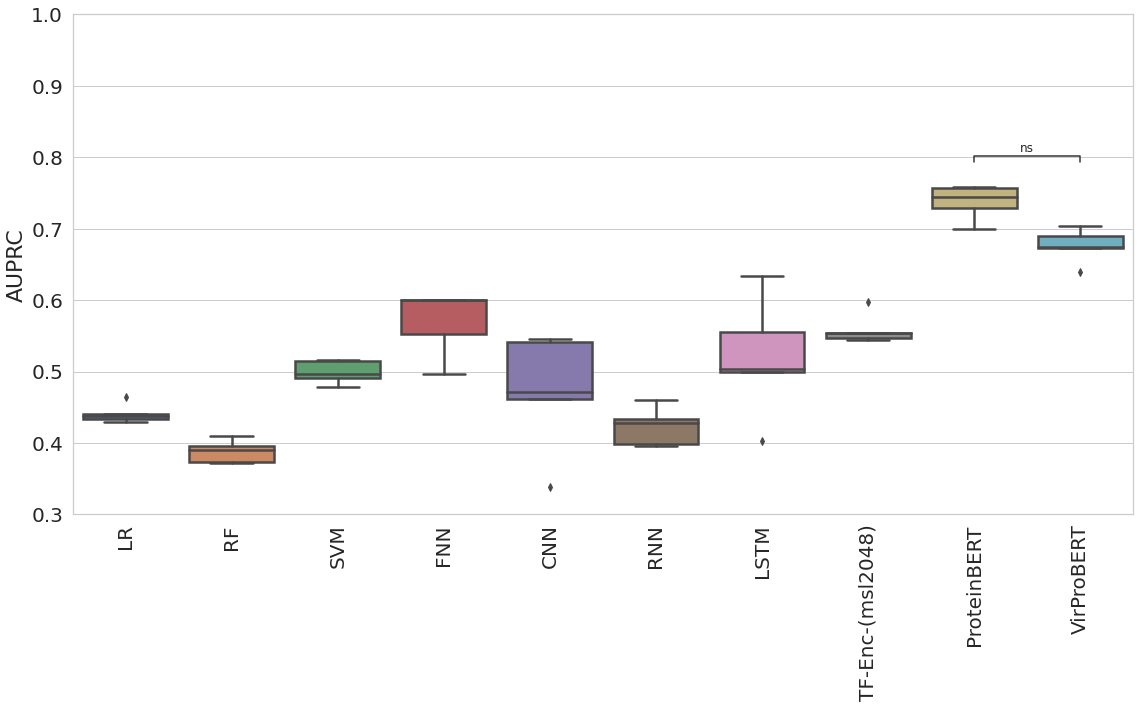

In [25]:
plot_boxplot_w_stat_tests(sub_df, "auprc", "outside", ylim=(0.3, 1))

In [13]:
plot_boxplot_w_stat_tests(df, "auroc", location="outside", ylim=(0.8, 1.0))

ValueError: Could not interpret input 'auroc'

<Figure size 432x288 with 0 Axes>

<Figure size 1152x720 with 0 Axes>